MNIST Classification Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from engine.engine import Engine

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
X, y = mnist.data, mnist.target.astype(int)

In [3]:
# Preprocess the data
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
def one_hot_encode(y, num_classes=10):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

In [4]:
# Define a simple feedforward neural network
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.w1 = Engine(np.random.randn(input_size, hidden_size), requires_grad=True)
        self.b1 = Engine(np.zeros(hidden_size), requires_grad=True)
        self.w2 = Engine(np.random.randn(hidden_size, output_size), requires_grad=True)
        self.b2 = Engine(np.zeros(output_size), requires_grad=True)

    def forward(self, x):
        # Hidden layer (ReLU activation)
        self.z1 = x.matmul(self.w1) + self.b1
        self.a1 = Engine(np.maximum(0, self.z1.data), requires_grad=False)  # ReLU activation

        # Output layer (softmax activation)
        self.z2 = self.a1.matmul(self.w2) + self.b2
        # Numerical stability improvement for softmax
        if self.z2.data.ndim == 1:
            z2_stable = self.z2.data - np.max(self.z2.data)
            exp_scores = np.exp(z2_stable)
            self.a2 = exp_scores / np.sum(exp_scores)  # Softmax activation for single sample
        else:
            z2_stable = self.z2.data - np.max(self.z2.data, axis=1, keepdims=True)
            exp_scores = np.exp(z2_stable)
            self.a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # Softmax activation
        return self.a2

In [5]:
# Training the neural network
model = SimpleNN(input_size=784, hidden_size=128, output_size=10)
learning_rate = 0.01
epochs = 10
batch_size = 64

losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        # Mini-batch training
        X_batch = Engine(X_train[i:i + batch_size], requires_grad=False)
        y_batch = y_train_encoded[i:i + batch_size]

        # Forward pass
        predictions = model.forward(X_batch)

        # Cross-entropy loss with numerical stability
        predictions = np.clip(predictions, 1e-10, 1.0)  # Clip predictions to avoid log(0)
        log_likelihood = -np.log(predictions[range(len(y_batch)), y_batch.argmax(axis=1)])
        loss = np.sum(log_likelihood) / len(y_batch)
        epoch_loss += loss

        # Backward pass and update weights (Gradient Descent)
        grad_output = predictions - y_batch
        model.w2.grad = model.a1.transpose().matmul(Engine(grad_output)).data / len(y_batch)
        model.b2.grad = np.sum(grad_output, axis=0) / len(y_batch)

        grad_hidden = np.dot(grad_output, model.w2.data.T) * (model.z1.data > 0)
        model.w1.grad = X_batch.transpose().matmul(Engine(grad_hidden)).data / len(y_batch)
        model.b1.grad = np.sum(grad_hidden, axis=0) / len(y_batch)

        # Update weights
        model.w1.data -= learning_rate * model.w1.grad
        model.b1.data -= learning_rate * model.b1.grad
        model.w2.data -= learning_rate * model.w2.grad
        model.b2.data -= learning_rate * model.b2.grad

    avg_epoch_loss = epoch_loss / (X_train.shape[0] / batch_size)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}")

Epoch 1/10, Loss: 5.092428840658002
Epoch 2/10, Loss: 2.655072095672832
Epoch 3/10, Loss: 2.1512109537597817
Epoch 4/10, Loss: 1.8836734810041234
Epoch 5/10, Loss: 1.6878790268330948
Epoch 6/10, Loss: 1.5375945599691592
Epoch 7/10, Loss: 1.3990455938952668
Epoch 8/10, Loss: 1.3255909127506358
Epoch 9/10, Loss: 1.2466674430468236
Epoch 10/10, Loss: 1.1900548368713244


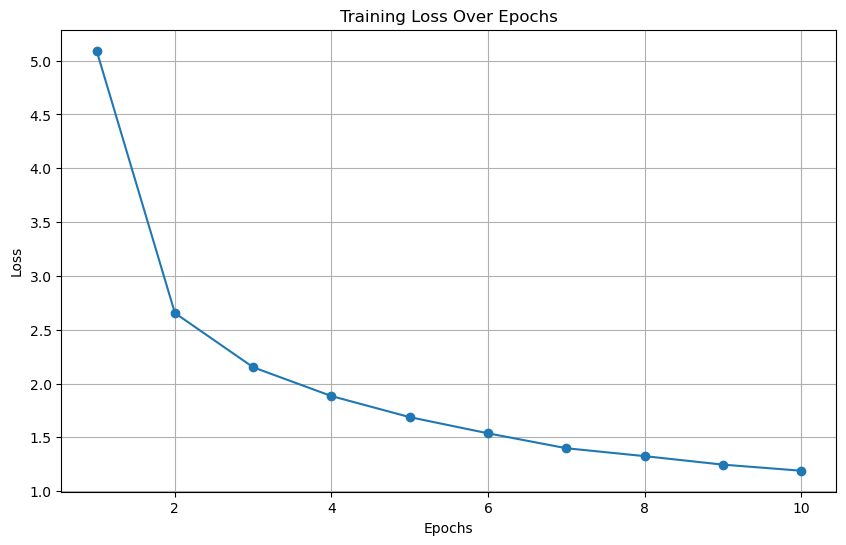

In [6]:
# Plot training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [7]:
# Testing the neural network
correct_predictions = 0
for i in range(X_test.shape[0]):
    x = Engine(X_test[i], requires_grad=False)
    prediction = model.forward(x)
    if np.argmax(prediction) == y_test.iloc[i]:
        correct_predictions += 1

accuracy = correct_predictions / X_test.shape[0]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 89.91%


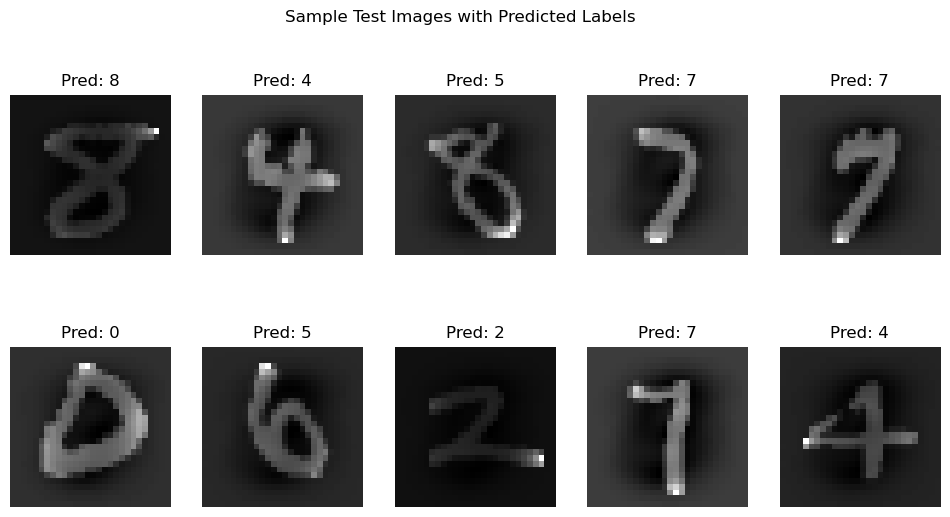

In [8]:
# Visualize some of the test samples along with predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    x = Engine(X_test[i], requires_grad=False)
    prediction = model.forward(x)
    predicted_label = np.argmax(prediction)
    axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Pred: {predicted_label}')
    axes[i].axis('off')

plt.suptitle('Sample Test Images with Predicted Labels')
plt.show()